In [1]:
from ase.io import read, write
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones
from castle import utils, LinearPotential, LPEnsemble, LPLocalEnsemble, print_score, AceRepresentation, ASEMLCalculator, ExpandedPotential
import dadapy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl


rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1, 'W':5.0, "P": 5.0}

%load_ext autoreload
%autoreload 2

## Data Preparation

In [2]:
# import os
# root = "/home/claudio/postdoc/data/P/P_test"
# test_traj = []
# for path, subdirs, files in os.walk(root):
#     for name in files:
#         if name.endswith(".xyz"):
#             traj_ = read(path + "/" + name, index = ':')
#             try:
#                 _ = [a.get_array("forces") for a in traj_]
#                 test_traj.extend(traj_)
#             except KeyError:
#                 print(f"{name} does not contain forces")
                
# write("/home/claudio/postdoc/data/P/test.xyz", test_traj)

bulk.xyz does not contain forces
bulk_all.xyz does not contain forces
Hittorf_Angew2020.vasp_STEPS.xyz does not contain forces
Hittorf_ActaB1969.vasp_STEPS.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces
bulk.xyz does not contain forces


/home/claudio/.local/lib/python3.8/site-packages/ase/io/extxyz.py:997: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


In [2]:
species = 'P'
N = 4
maxdeg = 12
rcut = rcuts[species]
force_name = 'forces'
energy_name = 'energy'
e_noise = 1e-8
f_noise = 1e-8
root = f"/home/claudio/postdoc/data/{species}/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz", 
#                                                    N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
#                                                    energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz", 
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",  f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

In [3]:
filter = e_val/nat_val < np.quantile(e_val/nat_val, 0.99)
f_val_ = []
start = 0
for i, s in enumerate(val_features.get_nb_atoms_per_frame()):
    if filter[i]:
        f_val_.extend(f_val[start:start+s])
    start += s
f_val_ = np.array(f_val_)
val_features_ = val_features.get_subset(np.arange(len(e_val))[filter])
e_val_ = e_val[filter]
nat_val_ = nat_val[filter]

## Linear Model

CPU times: user 74.4 ms, sys: 156 ms, total: 231 ms
Wall time: 29.1 ms
MAE=0.106 RMSE=0.328 SUP=4.764 R2=0.801
MAE=0.229 RMSE=0.378 SUP=45.084 R2=0.861


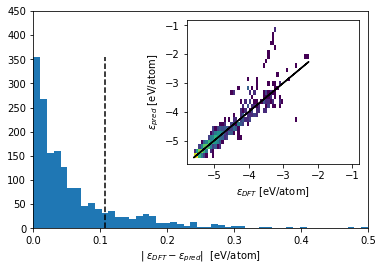

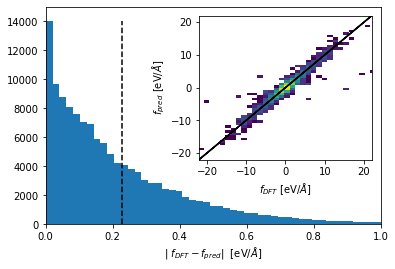

In [16]:
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())


fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(e_val_/nat_val_- ep/nat_val_), bins = np.linspace(0, .5, 50))
ax.vlines(np.mean(abs(e_val_/nat_val_- ep/nat_val_)), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(e_val_/nat_val_, ep/nat_val_, cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(e_val_/nat_val_, e_val_/nat_val_, 'k-')
ax_new.set_xlabel("$\epsilon_{DFT}$ [eV/atom]")
ax_new.set_ylabel("$\epsilon_{pred}$ [eV/atom]")
ax_new.set_xlim(-5.8, -0.8)
ax_new.set_ylim(-5.8, -0.8)
ax.set_xlim(0, .5)
ax.set_xlabel("| $\epsilon_{DFT}- \epsilon_{pred}|$  [eV/atom]")
ax.set_ylim(0, 450)
plt.savefig(f"../../plots/divide/validation_energy_error_{species}_linear_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(f_val_.ravel() - fp.ravel()), bins = np.linspace(0, 1, 50))
ax.vlines(np.mean(abs(f_val_.ravel() - fp.ravel())), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(f_val_.ravel(), fp.ravel(), cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(f_val_.ravel(), f_val_.ravel(), 'k-')
ax_new.set_xlabel("$f_{DFT}$ [eV/$\AA$]")
ax_new.set_ylabel("$f_{pred}$ [eV/$\AA$]")
ax_new.set_xlim(-22, 22)
ax_new.set_ylim(-22, 22)
ax.set_xlim(0, 1)
ax.set_ylim(0, 15000)
ax.set_xlabel("| $f_{DFT}- f_{pred}|$  [eV/$\AA$]")
plt.savefig(f"../../plots/divide/validation_force_error_{species}_linear_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

In [19]:
ind_scacato = (e_val_/nat_val_ < -3) & (ep/nat_val_ > -2.6) 

CPU times: user 218 ms, sys: 368 ms, total: 586 ms
Wall time: 102 ms
MAE=0.058 RMSE=0.102 SUP=1.422 R2=0.956
MAE=0.230 RMSE=0.338 SUP=8.293 R2=0.920


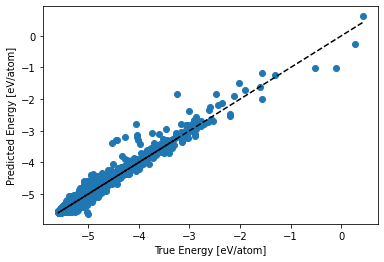

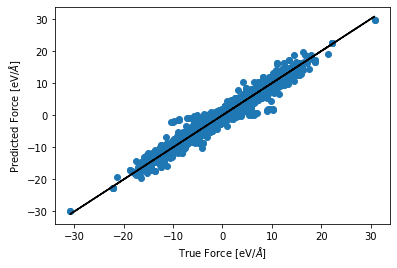

In [43]:
%time predictions = model_lin.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
print_score(ft.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 76.4 ms, sys: 158 ms, total: 234 ms
Wall time: 29.8 ms
MAE=0.075 RMSE=0.180 SUP=2.393 R2=0.921
MAE=0.220 RMSE=0.325 SUP=5.235 R2=0.901


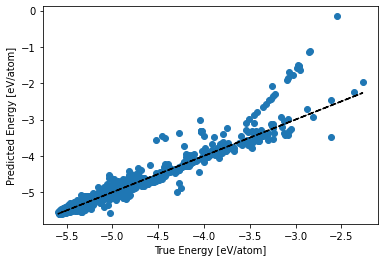

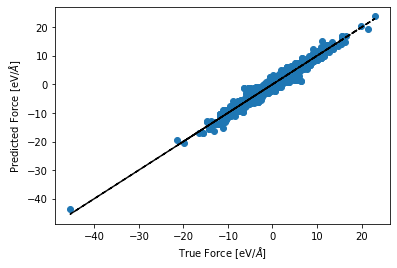

In [56]:
model_lin.update_from_features(val_features_, e_val_, f_val_)# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())

plt.scatter(e_val_/nat_val_, ep/nat_val_)
plt.plot(e_val_/nat_val_, e_val_/nat_val_, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val_, fp)
plt.plot(f_val_, f_val_, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# Ensemble Model

Clustering data
Using 6 clusters
CPU times: user 2.98 s, sys: 616 ms, total: 3.6 s
Wall time: 2.81 s
MAE=0.055 RMSE=0.114 SUP=1.014 R2=0.960
MAE=0.220 RMSE=0.336 SUP=12.100 R2=0.896


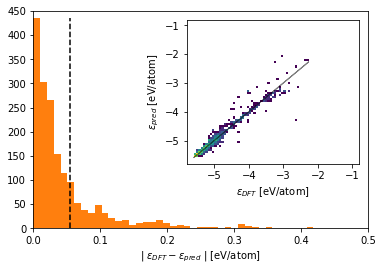

ValueError: operands could not be broadcast together with shapes (1775,) (15,) 

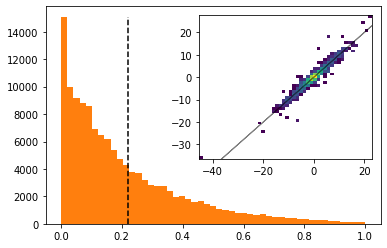

In [44]:
# train the model
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_ens = LPEnsemble(representation, n_clusters=6, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())

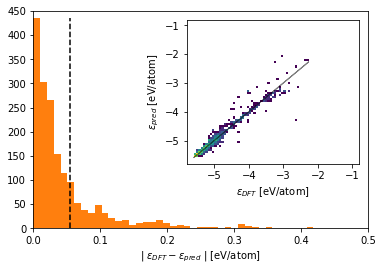

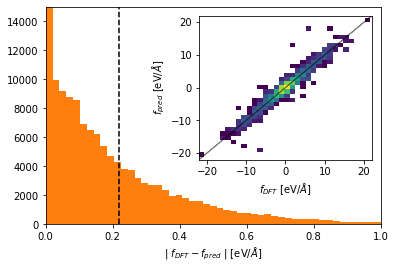

In [47]:

fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(e_val_/nat_val_- ep/nat_val_), bins = np.linspace(0, .5, 50), color = 'tab:orange')
ax.vlines(np.mean(abs(e_val_/nat_val_- ep/nat_val_)), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.hist2d(e_val_/nat_val_, ep/nat_val_, cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.plot(e_val_/nat_val_, e_val_/nat_val_, 'k-', lw=1, alpha=.5)
ax_new.set_xlabel("$\epsilon_{DFT}$ [eV/atom]")
ax_new.set_ylabel("$\epsilon_{pred}$ [eV/atom]")
ax_new.set_xlim(-5.8, -.8)
ax_new.set_ylim(-5.8, -.8)
ax.set_xlim(0, .5)
ax.set_ylim(0, 450)
ax.set_xlabel("| $\epsilon_{DFT}- \epsilon_{pred}$ | [eV/atom]")
plt.savefig(f"../../plots/divide/validation_energy_error_{species}_ensemble_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

fig, ax = plt.subplots()
left, bottom, width, height = [.48, 0.35, 0.4, 0.5]
ax_new = fig.add_axes([left, bottom, width, height])
hist = ax.hist(abs(f_val_.ravel() - fp.ravel()), bins = np.linspace(0, 1, 50), color = 'tab:orange')
ax.vlines(np.mean(abs(f_val_.ravel() - fp.ravel())), 0, max(hist[0]), color= 'k', linestyle = '--', lw = 1.5)
ax_new.plot(f_val_.ravel(), f_val_.ravel(), 'k-', lw=1, alpha=.5)
ax_new.hist2d(f_val_.ravel(), fp.ravel(), cmin=1e-12, bins = 50, norm=mpl.colors.LogNorm())
ax_new.set_xlabel("$f_{DFT}$ [eV/$\AA$]")
ax_new.set_ylabel("$f_{pred}$ [eV/$\AA$]")
ax_new.set_xlim(-22, 22)
ax_new.set_ylim(-22, 22)
ax.set_xlim(0, 1)
ax.set_ylim(0, 15000)
ax.set_xlabel("| $f_{DFT}- f_{pred}$ | [eV/$\AA$]")
plt.savefig(f"../../plots/divide/validation_force_error_{species}_ensemble_N_{N}_maxdeg_{maxdeg}.pdf")
plt.show()

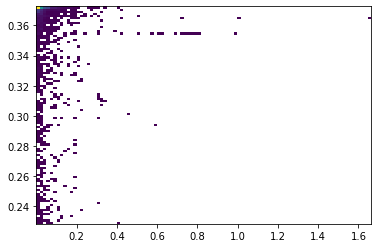

In [58]:
plt.hist2d(abs(e_val_/nat_val_- ep/nat_val_), np.std(model_ens.predicted_weights, axis = 1), bins = 100, cmin = 1e-12)
plt.show()

In [43]:
np.where(model_ens.clustering.labels == 1)[0]

array([1178, 1179, 1180, 1181, 1182, 1183, 1184, 2224, 2228, 2232, 2248,
       3862, 3998, 4239, 4741, 4755, 4762, 4765, 4766, 4770, 4779, 4780])

In [60]:
np.where(ind_scacato)

(array([ 62, 879, 884, 885, 892, 897, 898, 899, 904, 905, 910, 915, 920,
        934, 959]),)

CPU times: user 4.13 s, sys: 0 ns, total: 4.13 s
Wall time: 4.13 s
MAE=0.047 RMSE=0.083 SUP=0.987 R2=0.970
MAE=0.211 RMSE=0.316 SUP=7.429 R2=0.930


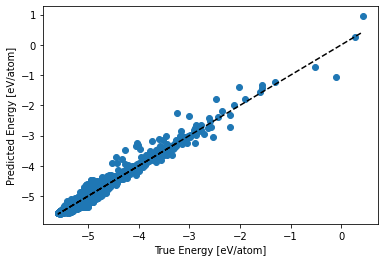

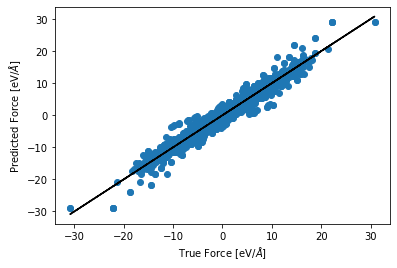

In [54]:
%time predictions = model_ens.predict_from_features(tr_features, forces=True)
et = predictions['energy']
ft = predictions['forces']
print_score(et/nat_tr, e_t/nat_tr)
print_score(ft.flatten(), f_t.flatten())

plt.scatter(e_t/nat_tr, et/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, ft)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 1.67 s, sys: 655 ms, total: 2.33 s
Wall time: 1.52 s
MAE=0.054 RMSE=0.112 SUP=0.714 R2=0.957
MAE=0.201 RMSE=0.296 SUP=5.301 R2=0.917


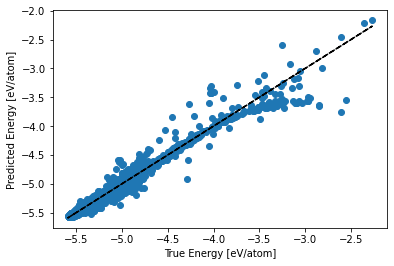

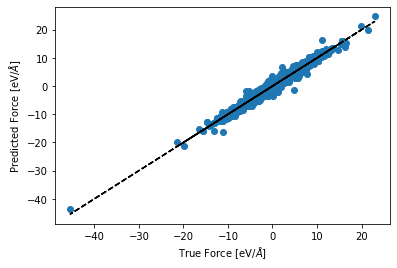

In [55]:
model_ens.update_from_features(val_features_, e_val_, f_val_)# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features_, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val_, e_val_/nat_val_)
print_score(fp.flatten(), f_val_.flatten())

plt.scatter(e_val_/nat_val_, ep/nat_val_)
plt.plot(e_val_/nat_val_, e_val_/nat_val_, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val_, fp)
plt.plot(f_val_, f_val_, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

## Density Analysis

In [7]:
tr_local_features, val_local_features = utils.extract_local_features(root, "train.xyz", "test.xyz", 
                                                   N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
                                                   energy_name=energy_name, species=species, compute_derivative=False)

In [23]:
X = []
for i in tr_local_features.X:
    X.extend(i[:, :-1])
X = np.array(X)

Y = []
for i, x in enumerate(val_local_features.X):
    if filter[i]:
        Y.extend(x[:, :-1])
Y = np.array(Y)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

X_ = (X - mean[None, :])
Y_ = (Y - mean[None, :]) 

np.save(root + f"tr_local_features_N{N}_maxdeg{maxdeg}.npy", X_)
np.save(root + f"val_local_features_N{N}_maxdeg{maxdeg}.npy", Y_)

In [9]:
X_ = np.load(root + f"tr_local_features_N{N}_maxdeg{maxdeg}.npy", allow_pickle=True)
Y_ = np.load(root + f"val_local_features_N{N}_maxdeg{maxdeg}.npy", allow_pickle=True)

data = dadapy.Data(X_)
data.compute_distances(maxk = 1000)
data.compute_id_2NN()
dens_tr , dens_tr_err = data.compute_density_kstarNN()
dens_val, dens_val_err = data.return_interpolated_density_kstarNN(Y_)

/home/claudio/.local/lib/python3.8/site-packages/dadapy/_utils/utils.py:150: UserWarning: there may be data with zero distance from each other; this may compromise the correct behavior of some routines
  warnings.warn(
/home/claudio/.local/lib/python3.8/site-packages/dadapy/id_estimation.py:167: RuntimeWarning: divide by zero encountered in true_divide
  mus[j] = np.log(distances[:, 2] / distances[:, 1])


In [11]:
np.save(root + f"tr_local_features_density_kstarNN_N{N}_maxdeg{maxdeg}.npy", dens_tr)
np.save(root + f"val_local_features_density_kstarNN_N{N}_maxdeg{maxdeg}.npy", dens_val)

In [4]:
dens_tr = np.load(root + f"tr_local_features_density_kstarNN_N{N}_maxdeg{maxdeg}.npy", allow_pickle = True)
dens_val = np.load(root + f"val_local_features_density_kstarNN_N{N}_maxdeg{maxdeg}.npy", allow_pickle = True)

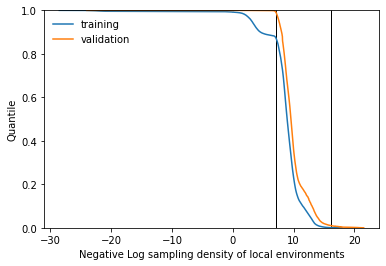

In [5]:
isnotna_val = ~np.isnan(dens_val)
isnotna_tr = ~np.isnan(dens_tr)

low = int(np.quantile(np.concatenate([dens_val[isnotna_val], dens_tr[isnotna_tr]]), .01))
high = int(np.quantile(np.concatenate([dens_val[isnotna_val], dens_tr[isnotna_tr]]), .99))
low = np.quantile(dens_val[isnotna_val], .01)
high = np.quantile(dens_val[isnotna_val], .99)

plt.plot(-np.sort(dens_tr), np.arange(len(dens_tr))/len(dens_tr), label = 'training')
plt.plot(-np.sort(dens_val), np.arange(len(dens_val))/len(dens_val), label = 'validation')
plt.vlines(-low, 0, 1, 'k', lw = 1)
plt.vlines(-high, 0, 1, 'k', lw =1)
plt.legend(loc=2, frameon=False)
plt.xlabel("Negative Log sampling density of local environments")
plt.ylabel("Quantile")
plt.ylim(0, 1)
plt.show()

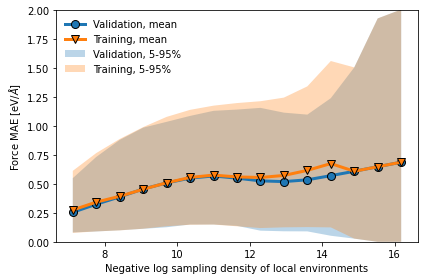

In [6]:
ncenter = 15
model = 'linear'

representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
if model == 'linear':
    model_ = LinearPotential(representation)
elif model == 'ensemble':
    model_ = LPEnsemble(representation, n_clusters=6, clustering_type='kmeans', baseline_percentile=0)
model_.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
predictions_val = model_.predict_from_features(val_features_, forces=True)
ep = predictions_val['energy']
fp = predictions_val['forces']

denss = dens_val
errss = np.linalg.norm(fp - f_val_, axis = 1) #/ (1e-3+np.linalg.norm(f_val_, axis = 1))

plt.figure(figsize = (6, 4))
centers = np.linspace(low, high, ncenter)
binwidth = (high - low) / (len(centers))*2
binned_error = np.empty(len(centers))*np.nan
binned_error_std = np.empty(len(centers))*np.nan
binned_error_95 = np.empty(len(centers))*np.nan
binned_error_5 = np.empty(len(centers))*np.nan

for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        binned_error_95[cc] = np.quantile(errss[ind], .95)
        binned_error_5[cc] = np.quantile(errss[ind], .05)

plt.plot(-centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'o', label = 'Validation, mean')
# plt.plot(centers, binned_error_95, lw = 3,
#          markersize = 8,mec = 'k', marker = 'o', linestyle = ':', color = 'tab:blue', label = 'Validation, 95%')
plt.fill_between(-centers, binned_error_95, binned_error_5, alpha = 0.3, label = 'Validation, 5-95%')


predictions_tr = model_.predict_from_features(tr_features, forces=True)
et = predictions_tr['energy']
ft = predictions_tr['forces']
denss = dens_tr
errss = np.linalg.norm(ft - f_t, axis = 1)#/ (1e-3+np.linalg.norm(f_t, axis = 1))
for cc, c in enumerate(centers):
    ind = (denss < c + binwidth) & (denss > c - binwidth)
    if sum(ind)/len(denss) > 0.02:
        binned_error[cc] = np.mean(errss[ind])
        binned_error_std[cc] = np.std(errss[ind])
        binned_error_95[cc] = np.quantile(errss[ind], .95)
        binned_error_5[cc] = np.quantile(errss[ind], .05)

plt.plot(-centers, binned_error, lw = 3,
         markersize = 8,mec = 'k', marker = 'v', label = 'Training, mean')
# plt.plot(centers, binned_error_95, lw = 3,
#          markersize = 8,mec = 'k', marker = 'v', linestyle = ':', color = 'tab:orange', label = 'Training, 95%')
plt.fill_between(-centers, binned_error_95, binned_error_5, alpha = 0.3, label = 'Training, 5-95%')
plt.xlabel("Negative log sampling density of local environments")
plt.ylabel("Force MAE [eV/$\AA$]")

plt.legend(frameon=False, loc=2)
plt.ylim(0, 2)
plt.tight_layout()
plt.savefig(f"../../plots/divide/energy_error_vs_sanpling_density_{species}_{model}.pdf")

In [28]:
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
def orthogonalise_cols(X,i):
     # i : index of point selected at CUR round
     # X : feature matrix
    Xt = X.copy()
    v = Xt[:,i]/np.sqrt(np.matmul(Xt[:,i],Xt[:,i]))
    for col in range(Xt.shape[1]):
        Xt[:,col] = X[:,col] - v*np.dot(v,Xt[:,col])
    return Xt

def orthogonalise_rows(X,i):
     # i : index of point selected at CUR round
     # X : feature matrix
    Xt = X.copy()
    v = Xt[i]/np.sqrt(np.matmul(Xt[i],Xt[i]))
    for row in range(Xt.shape[0]):
        Xt[row] = X[row] - v*np.dot(v,Xt[row])
    return Xt
def cur_once(K,k,indices):
    # K :   kernel matrix obtained by np.dot(X,X.T)
    # k :   depth of our cur sum (how many eigenvectors components contribute
    # to the importance score - don't overthink it)
    # indices : list of indices we update at every iteration
    v,U = eigs(K,k=k)
    U = U[:,np.flip(np.argsort(v))]
    pi = (np.real(U)[:,:k]**2).sum(axis=1)
    pi[indices]= 0
    indices.append(pi.argmax())
    pass
def cur_once_cost(K,k,indices,cost):
    # K :   kernel matrix obtained by np.dot(X,X.T)
    # k :   depth of our cur sum (how many eigenvectors components contribute
    # to the importance score)
    # indices : list of indices we update at every iteration
    v,U = eigs(K,k=k)
    U = U[:,np.flip(np.argsort(v))]
    #The cost enters in the Pi score vectors by dividing it.
    pi = (np.real(U)[:,:k]**2).sum(axis=1)/cost 
    pi[indices]= 0
    #The column with the highest score is selected
    indices.append(pi.argmax())
    pass

def do_cur(X,k,n):
    indices = []
    K = np.dot(X,X.T)
    Xn = X
    for n in range(n):
        cur_once(K,k,indices)
        Xn = orthogonalise_cols(Xn.T,indices[-1]).T # called on the last index (-1)
        K = np.dot(Xn,Xn.T)
    return indices

def do_cost_cur(X,k,n,cost):
    indices = []
    K = np.dot(X,X.T)
    Xn = X
    for n in range(n):
        cur_once_cost(K,k,indices,cost)
        Xn = orthogonalise_cols(Xn.T,indices[-1]).T # called on the last index (-1)
        K = np.dot(Xn,Xn.T)
    return indices

## Active Learning

In [23]:
local_to_global_map = np.zeros(len(dens_tr), dtype='int')
tot = 0
for i, n in enumerate(tr_features.get_nb_atoms_per_frame()):
    local_to_global_map[tot:tot+n] = i
    tot+=n
    
global_prob = np.array([max(-dens_tr[local_to_global_map == i]) for i in range(len(tr_features.X))])
global_prob -= np.min(global_prob)
global_prob /= sum(global_prob)

In [54]:
model_names = ['linear', 'ensemble']
models = [LinearPotential(representation), LPEnsemble(representation, n_clusters=4, clustering_type='kmeans', baseline_percentile=0)]

ns = [100, 200, 500, 1000, 2000, 4000]
reps = 10

# results = {}
for model_name, model_ in zip(model_names, models):
    mae_e_rand, mae_f_rand, rmse_e_rand, rmse_f_rand = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))
    mae_e_dens, mae_f_dens, rmse_e_dens, rmse_f_dens = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))
    mae_e_cur, mae_f_cur, rmse_e_cur, rmse_f_cur = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))
    mae_e_knn, mae_f_knn, rmse_e_knn, rmse_f_knn = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))
    
    # results[model_name] = {}
    for i, n in enumerate(ns):
        for r in np.arange(reps):
            print(n, r)

            # DENS
#             inds_dens = np.random.choice(range(len(tr_features.X)), n, replace=False,  p = global_prob)
#             f_t_ = []
#             for j in inds_dens:
#                 f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
#             f_t_ = np.array(f_t_)
#             model_.fit_from_features(tr_features.get_subset(inds_dens), e_t[inds_dens], f_t_, e_noise, f_noise, noise_optimization=False)
#             predictions_val = model_.predict_from_features(val_features_, forces=True)
#             ep = predictions_val['energy']
#             fp = predictions_val['forces']
#             mae_e_dens[i, r], rmse_e_dens[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
#             mae_f_dens[i, r], rmse_f_dens[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())

#             # RAND
#             inds_rand = np.random.choice(range(len(tr_features.X)), n, replace=False)
#             f_t_ = []
#             for j in inds_rand:
#                 f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
#             f_t_ = np.array(f_t_)
#             model_.fit_from_features(tr_features.get_subset(inds_rand), e_t[inds_rand], f_t_, e_noise, f_noise, noise_optimization=False)
#             predictions_val = model_.predict_from_features(val_features_, forces=True)
#             ep = predictions_val['energy']
#             fp = predictions_val['forces']
#             mae_e_rand[i, r], rmse_e_rand[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
#             mae_f_rand[i, r], rmse_f_rand[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())

            # WEIGHTED CUR
            # inds_rand = do_cost_cur(tr_features.X, 2, n, global_prob)
            # f_t_ = []
            # for j in inds_rand:
            #     f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
            # f_t_ = np.array(f_t_)
            # model_.fit_from_features(tr_features.get_subset(inds_rand), e_t[inds_rand], f_t_, e_noise, f_noise, noise_optimization=False)
            # predictions_val = model_.predict_from_features(val_features_, forces=True)
            # ep = predictions_val['energy']
            # fp = predictions_val['forces']
            # mae_e_cur[i, r], rmse_e_cur[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
            # mae_f_cur[i, r], rmse_f_cur[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())


            # KNN
            neigh = KMeans(n_clusters=n).fit(np.concatenate([tr_features.X, tr_features.X_std], axis = 1))
            inds_rand = np.array([np.random.choice(np.arange(len(tr_features.X))[neigh.labels_ == i]) for i in np.arange(n)])
            # inds_rand = np.random.choice(range(len(tr_features.X)), n, replace=False)
            f_t_ = []
            for j in inds_rand:
                f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
            f_t_ = np.array(f_t_)
            model_.fit_from_features(tr_features.get_subset(inds_rand), e_t[inds_rand], f_t_, e_noise, f_noise, noise_optimization=False)
            predictions_val = model_.predict_from_features(val_features_, forces=True)
            ep = predictions_val['energy']
            fp = predictions_val['forces']
            mae_e_knn[i, r], rmse_e_knn[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
            mae_f_knn[i, r], rmse_f_knn[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())
            
            # results[model_name]['energy'] = {}
            # results[model_name]['force'] = {}
            # results[model_name]['energy']['rmse'] = {}
            # results[model_name]['force']['rmse'] = {}
            # results[model_name]['energy']['mae'] = {}
            # results[model_name]['force']['mae'] = {}

            # results[model_name]['energy']['rmse']['dens'] = rmse_e_dens.tolist()
            # results[model_name]['energy']['rmse']['rand'] = rmse_e_rand.tolist()
            # # results[model_name]['energy']['rmse']['cur'] = rmse_e_cur
            results[model_name]['energy']['rmse']['knn'] = rmse_e_knn
            # results[model_name]['energy']['mae']['dens'] = mae_e_dens.tolist()
            # results[model_name]['energy']['mae']['rand'] = mae_e_rand.tolist()
            # # results[model_name]['energy']['mae']['cur'] = mae_e_cur
            results[model_name]['energy']['mae']['knn'] = mae_e_knn
            # results[model_name]['force']['rmse']['dens'] = rmse_f_dens.tolist()
            # results[model_name]['force']['rmse']['rand'] = rmse_f_rand.tolist()
            # # results[model_name]['force']['rmse']['cur'] = rmse_f_cur
            results[model_name]['force']['rmse']['knn'] = rmse_f_knn
            # results[model_name]['force']['mae']['dens'] = mae_f_dens.tolist()
            # results[model_name]['force']['mae']['rand'] = mae_f_rand.tolist()
            # # results[model_name]['force']['mae']['cur'] = mae_f_cur
            results[model_name]['force']['mae']['knn'] = mae_f_knn

100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
200 0
200 1
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
1000 0
1000 1
1000 2
1000 3
1000 4
1000 5
1000 6
1000 7
1000 8
1000 9
2000 0
2000 1
2000 2
2000 3
2000 4
2000 5
2000 6
2000 7
2000 8
2000 9
4000 0
4000 1
4000 2
4000 3
4000 4
4000 5
4000 6
4000 7
4000 8
4000 9
100 0
Clustering data
Using 4 clusters
100 1
Clustering data
Using 4 clusters
100 2
Clustering data
Using 4 clusters
100 3
Clustering data
Using 4 clusters
100 4
Clustering data
Using 4 clusters
100 5
Clustering data
Using 4 clusters
100 6
Clustering data
Using 4 clusters
100 7
Clustering data
Using 4 clusters
100 8
Clustering data
Using 4 clusters
100 9
Clustering data
Using 4 clusters
200 0
Clustering data
Using 4 clusters
200 1
Clustering data
Using 4 clusters
200 2
Clustering data
Using 4 clusters
200 3
Clustering data
Using 4 clusters
200 4
Clustering data
Using 4 clusters
200 5
Clustering data
Usi

In [56]:
import json

with open(f"learning_curves_{species}_N_{N}_maxdeg_{maxdeg}_v2.json", 'w') as f:
    json.dump(results, f, separators=(',', ':'), 
          sort_keys=True, 
          indent=4, cls=NumpyEncoder)

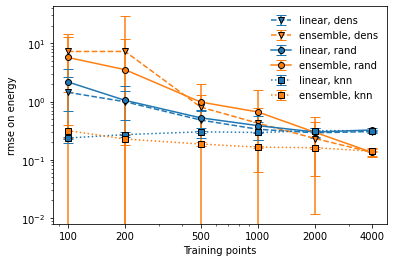

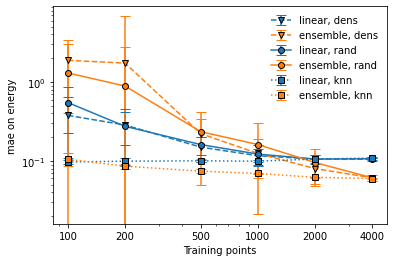

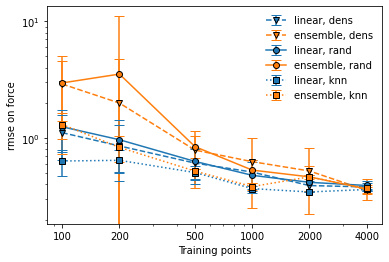

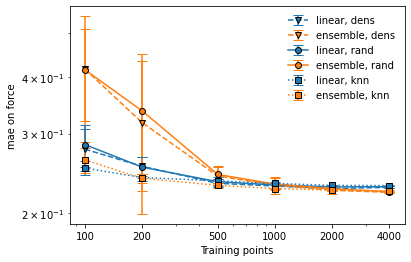

In [79]:
markers = {'dens':'v', 'rand':'o', 'knn':'s'}
colors = {'linear':'tab:blue', 'ensemble':'tab:orange'}
linestyles = {'dens':'--', 'rand':'-', 'knn':':'}

for variable_name, variable in results['linear'].items():
    for stat_name, stat in variable.items():
        for method_name, method in stat.items():
            for model_name, model in results.items():
                toplot = results[model_name][variable_name][stat_name][method_name]
                plt.errorbar(ns, np.mean(toplot, axis = 1), yerr = np.std(toplot, axis = 1), color = colors[model_name], mec = 'black',
                     label = f'{model_name}, {method_name}', marker = markers[method_name], capsize = 5, linestyle = linestyles[method_name])
        plt.xscale('log')
        plt.xticks(ns, ns)
        # plt.ylim(5e-2, 3)
        plt.xlabel("Training points")
        plt.yscale('log')
        plt.ylabel(f"{stat_name} on {variable_name}")
        plt.legend(frameon=False)
        plt.savefig(f"../../plots/divide/Training_curves_{stat_name}_{variable_name}_{species}_N_{N}_maxdeg_{maxdeg}.pdf")
        plt.show()

In [157]:
model_ = LPEnsemble(representation, n_clusters=4, clustering_type='kmeans', baseline_percentile=0)
    
ns = [100, 200, 500, 1000, 2000, 4000]
reps = 5
mae_e_rand_ens, mae_f_rand_ens, rmse_e_rand_ens, rmse_f_rand_ens = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))
mae_e_dens_ens, mae_f_dens_ens, rmse_e_dens_ens, rmse_f_dens_ens = np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps)), np.zeros((len(ns), reps))

for i, n in enumerate(ns):
    for r in np.arange(reps):
        print(n, r)
        inds_dens = np.random.choice(range(len(tr_features.X)), n, replace=False,  p = global_prob)
        f_t_ = []
        for j in inds_dens:
            f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
        f_t_ = np.array(f_t_)
        model_.fit_from_features(tr_features.get_subset(inds_dens), e_t[inds_dens], f_t_, e_noise, f_noise, noise_optimization=False)
        predictions_val = model_.predict_from_features(val_features_, forces=True)
        ep = predictions_val['energy']
        fp = predictions_val['forces']
        mae_e_dens_ens[i, r], rmse_e_dens_ens[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
        mae_f_dens_ens[i, r], rmse_f_dens_ens[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())
        
        
        inds_rand = np.random.choice(range(len(tr_features.X)), n, replace=False)
        f_t_ = []
        for j in inds_rand:
            f_t_.extend(f_t[tr_features.strides[j]:tr_features.strides[j+1]])
        f_t_ = np.array(f_t_)
        model_.fit_from_features(tr_features.get_subset(inds_rand), e_t[inds_rand], f_t_, e_noise, f_noise, noise_optimization=False)
        predictions_val = model_.predict_from_features(val_features_, forces=True)
        ep = predictions_val['energy']
        fp = predictions_val['forces']
        mae_e_rand_ens[i, r], rmse_e_rand_ens[i, r], _, __ = utils.get_score(ep/nat_val_, e_val_/nat_val_)
        mae_f_rand_ens[i, r], rmse_f_rand_ens[i, r], _, __ = utils.get_score(fp.flatten(), f_val_.flatten())

100 0
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


Clustering data
Using 4 clusters
100 1
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


100 2
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


100 3
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


100 4
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


200 0
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
200 1
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


200 2
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


200 3
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters


/home/claudio/postdoc/Castle/castle/clustering.py:105: RuntimeWarning: divide by zero encountered in true_divide
  self.precisions = 1/np.array([np.std(X_avg[self.labels == i], axis = 0) for i in range(self.n_clusters)])


200 4
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
500 0
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
500 1
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
500 2
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
500 3
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
500 4
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
1000 0
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
1000 1
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
1000 2
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
1000 3
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
1000 4
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
2000 0
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
2000 1
Clustering data
Using 4 clusters
Clustering data
Using 4 clusters
2000 2
Clustering data
Using 4 clusters
Clustering data
U

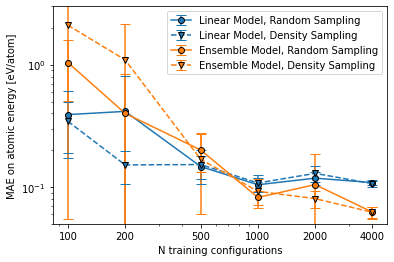

In [168]:
plt.errorbar(ns, np.mean(mae_e_rand, axis = 1), yerr = np.std(mae_e_rand, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(mae_e_dens, axis = 1), yerr = np.std(mae_e_dens, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.errorbar(ns, np.mean(mae_e_rand_ens, axis = 1), yerr = np.std(mae_e_rand_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(mae_e_dens_ens, axis = 1), yerr = np.std(mae_e_dens_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.xlabel("N training configurations")
plt.xscale('log')
plt.xticks(ns, ns)
plt.ylim(5e-2, 3)
plt.yscale('log')
plt.ylabel("MAE on atomic energy [eV/atom]")
plt.legend()
plt.savefig(f"../../plots/divide/Training_curves_energy_{species}_N_{N}_maxdeg_{maxdeg}.pdf")

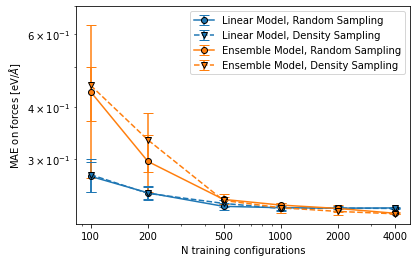

In [177]:
plt.errorbar(ns, np.mean(mae_f_rand, axis = 1), yerr = np.std(mae_f_rand, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(mae_f_dens, axis = 1), yerr = np.std(mae_f_dens, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.errorbar(ns, np.mean(mae_f_rand_ens, axis = 1), yerr = np.std(mae_f_rand_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(mae_f_dens_ens, axis = 1), yerr = np.std(mae_f_dens_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.xlabel("N training configurations")
plt.xscale('log')
plt.xticks(ns, ns)
plt.ylim(.21, .7)
plt.yscale('log')
plt.ylabel("MAE on forces [eV/$\AA$]")
plt.legend()
plt.savefig(f"../../plots/divide/Training_curves_force_{species}_N_{N}_maxdeg_{maxdeg}.pdf")

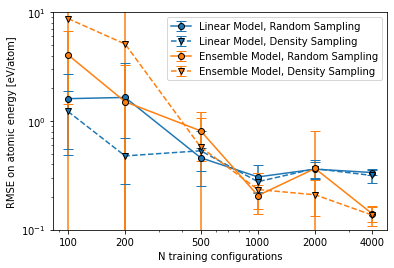

In [183]:
plt.errorbar(ns, np.mean(rmse_e_rand, axis = 1), yerr = np.std(rmse_e_rand, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(rmse_e_dens, axis = 1), yerr = np.std(rmse_e_dens, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.errorbar(ns, np.mean(rmse_e_rand_ens, axis = 1), yerr = np.std(rmse_e_rand_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(rmse_e_dens_ens, axis = 1), yerr = np.std(rmse_e_dens_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.xlabel("N training configurations")
plt.xscale('log')
plt.xticks(ns, ns)
plt.ylim(1e-1, 10)
plt.yscale('log')
plt.ylabel("RMSE on atomic energy [eV/atom]")
plt.legend()
plt.savefig(f"../../plots/divide/Training_curves_RMSE_energy_{species}_N_{N}_maxdeg_{maxdeg}.pdf")

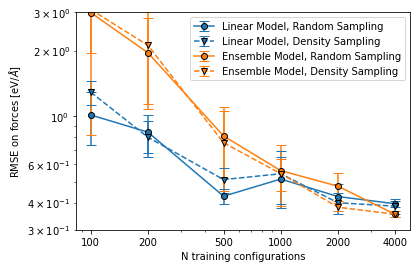

In [188]:
plt.errorbar(ns, np.mean(rmse_f_rand, axis = 1), yerr = np.std(rmse_f_rand, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(rmse_f_dens, axis = 1), yerr = np.std(rmse_f_dens, axis = 1), color = 'tab:blue', mec = 'black',
             label = 'Linear Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.errorbar(ns, np.mean(rmse_f_rand_ens, axis = 1), yerr = np.std(rmse_f_rand_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Random Sampling', marker = 'o', capsize = 5)
plt.errorbar(ns, np.mean(rmse_f_dens_ens, axis = 1), yerr = np.std(rmse_f_dens_ens, axis = 1), color = 'tab:orange', mec = 'black',
             label = 'Ensemble Model, Density Sampling', marker = 'v', capsize = 5, linestyle = '--')
plt.xlabel("N training configurations")
plt.xscale('log')
plt.xticks(ns, ns)
plt.ylim(.3, 3)
plt.yscale('log')
plt.ylabel("RMSE on forces [eV/$\AA$]")
plt.legend()
plt.savefig(f"../../plots/divide/Training_curves_RMSE_force_{species}_N_{N}_maxdeg_{maxdeg}.pdf")